In [1]:
import torch
import numpy as np
from nps.nps import NPsDecoder

z = np.load("./nps/latent_vectors/alum-bronze_latentVector.npy")
z = torch.from_numpy(z)
z = z.to('cuda').float()

module = NPsDecoder(z[0], z[1])
module.load_state_dict(torch.load('nps/model/decoder.pt'))
module = module.to('cuda').eval()

Could not open file


Text(0.5, 1.0, '2D Function Visualization (pred) fixed_angle = np.pi * 0.2')

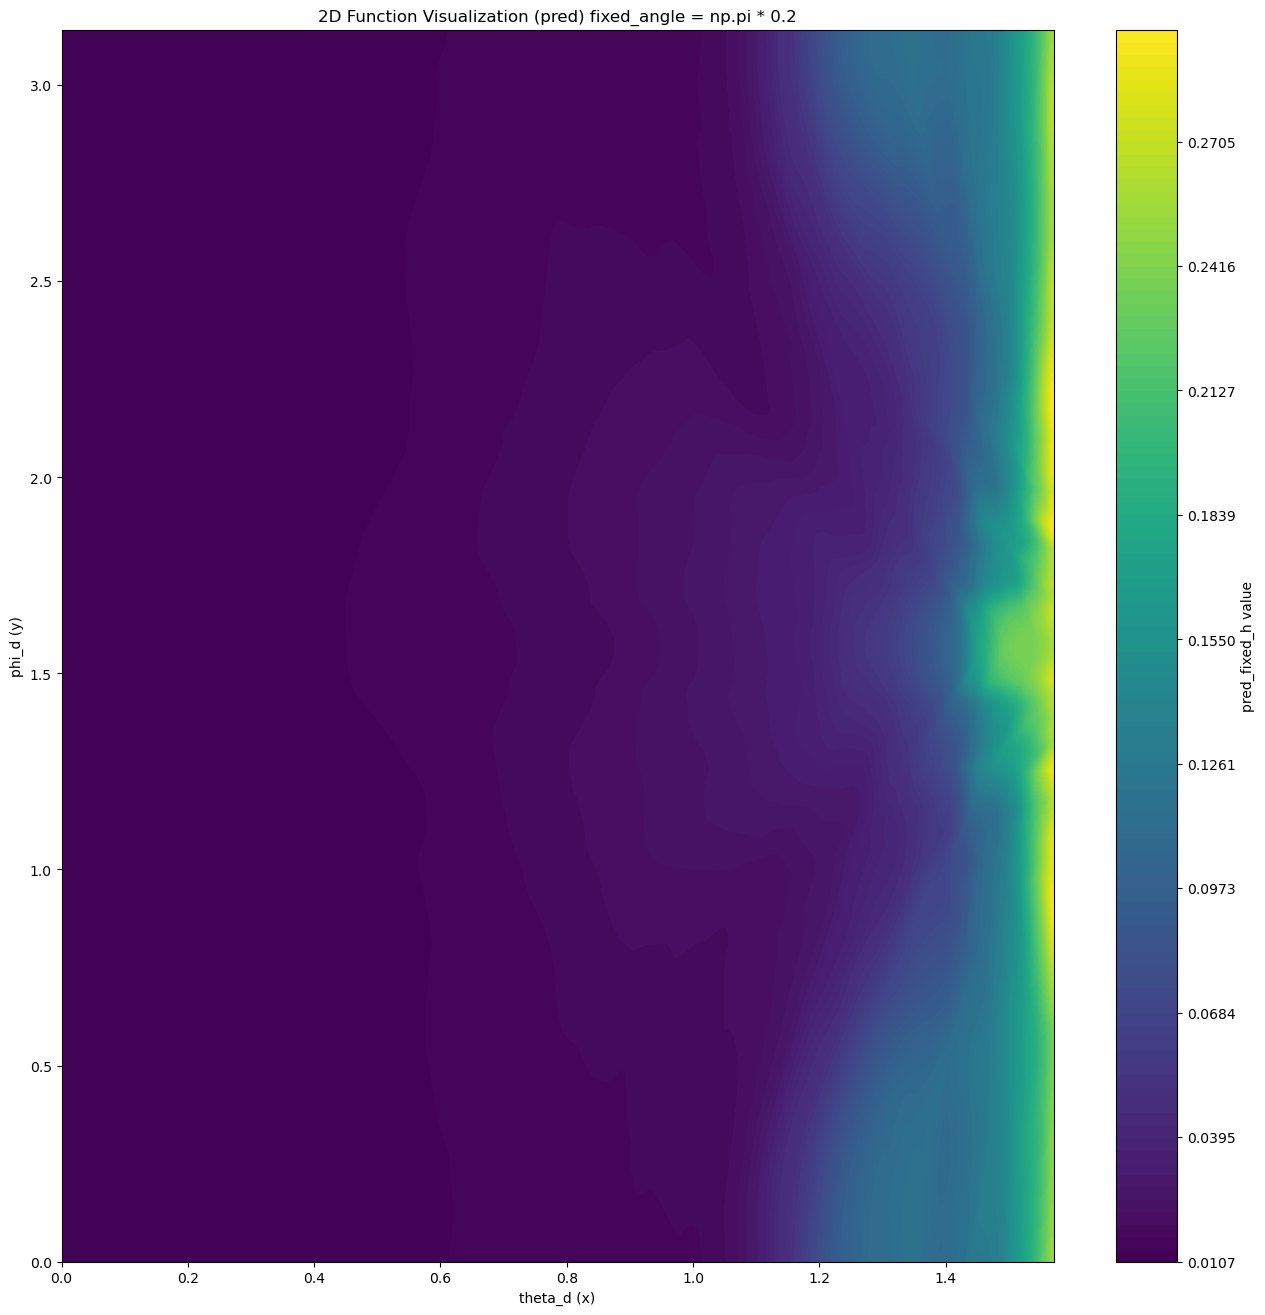

In [3]:
## test the learned model and visualize the results
import numpy as np
import torch
from tqdm import tqdm
from utils import *
import matplotlib.pyplot as plt

filename = "alum-bronze.binary"
model_path = "be_simple_mlp_"+ filename + ".pth"

fit_brdf = MeasuredBRDF(filename)
test_brdf = MeasuredBRDF("nps/test.binary")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_split = 360

theta_h = np.linspace(0, np.pi / 2, n_split)
theta_d = np.linspace(0, np.pi / 2, n_split)
phi_d = np.linspace(0, np.pi, n_split)

plane1_phi_d, plane2_phi_d = np.meshgrid(theta_h, theta_d)
plane1_theta_d, plane2_theta_d = np.meshgrid(theta_h, phi_d)
plane1_theta_h, plane2_theta_h = np.meshgrid(theta_d, phi_d)

plane1_phi_d, plane2_phi_d = plane1_phi_d.flatten(), plane2_phi_d.flatten()
plane1_theta_d, plane2_theta_d = plane1_theta_d.flatten(), plane2_theta_d.flatten()
plane1_theta_h, plane2_theta_h = plane1_theta_h.flatten(), plane2_theta_h.flatten()


fixed_angle = "np.pi * 0.2"
repeated_array = np.full(n_split**2, eval(fixed_angle))



theta_h_in = torch.from_numpy(repeated_array).float().to(device)
theta_d_in = torch.from_numpy(plane1_theta_h).float().to(device)
phi_d_in = torch.from_numpy(plane2_theta_h).float().to(device)
conca_in_fixed_h = torch.stack([theta_h_in, theta_d_in, phi_d_in], dim=1)

gt_fixed_h = fit_brdf.half_diff_look_up_brdf(
    repeated_array, plane1_theta_h, plane2_theta_h, use_interpolation=False
)

pred_fixed_h = module(phi_d_in, theta_h_in, theta_d_in).detach().cpu().numpy()
pred_fixed_h= np.clip(pred_fixed_h,0,None)
gt_fixed_h = gt_fixed_h.reshape(n_split, n_split,3)
pred_fixed_h = pred_fixed_h.reshape(n_split, n_split,3)

#visualize R channel

R_pred = pred_fixed_h[:,:,0]
R_gt = gt_fixed_h[:,:,0]
vmin = R_pred.min()
vmax = R_pred.max()
levels = np.linspace(vmin, vmax, 100)
plt.figure(figsize=(16, 16))
# plt.subplot(1, 2, 1)

plt.contourf(theta_d, phi_d, R_pred, cmap='viridis', levels=levels,vmin=vmin, vmax=vmax)
plt.colorbar(label='pred_fixed_h value')
plt.xlabel('theta_d (x)')
plt.ylabel('phi_d (y)')
plt.title('2D Function Visualization (pred) fixed_angle = '+ fixed_angle)

# plt.subplot(1, 2, 2)
# plt.contourf(theta_d, phi_d, R_gt, cmap='viridis', levels=levels,vmin=vmin, vmax=vmax)
# plt.colorbar(label='gt_fixed_h value')
# plt.xlabel('theta_d (x)')
# plt.ylabel('phi_d (y)')
# plt.title('2D Function Visualization (gt) fixed_angle = '+fixed_angle)
# plt.show()

